In [1]:
import sqlite3
import json
import pandas as pd
import glob
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotting_functions as pf

db_file = r"G:\Other computers\My Laptop\uni_honours_docs\getting_paper_ready\results.db"
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

datasets = [
    # 'letter_recognition',
    'car_evaluation',
    'mfeat-factors',
    'mfeat-fouriers',
    'mfeat-karhunen',
    'mfeat-morphological',
    'mfeat-pixel',
    'mfeat-zernlike',
    'optdigits',
    'pageblocks',
    'handwritten_digits',
    'satimage',
    'image_segment',
    'beans_data',
]

datasets += [
    "wine_quality",
    "academic_dropout",
    "maternal_health_risk",
    "rt_iot",
    "land_mines"
]

# Create Logistic Regression plots

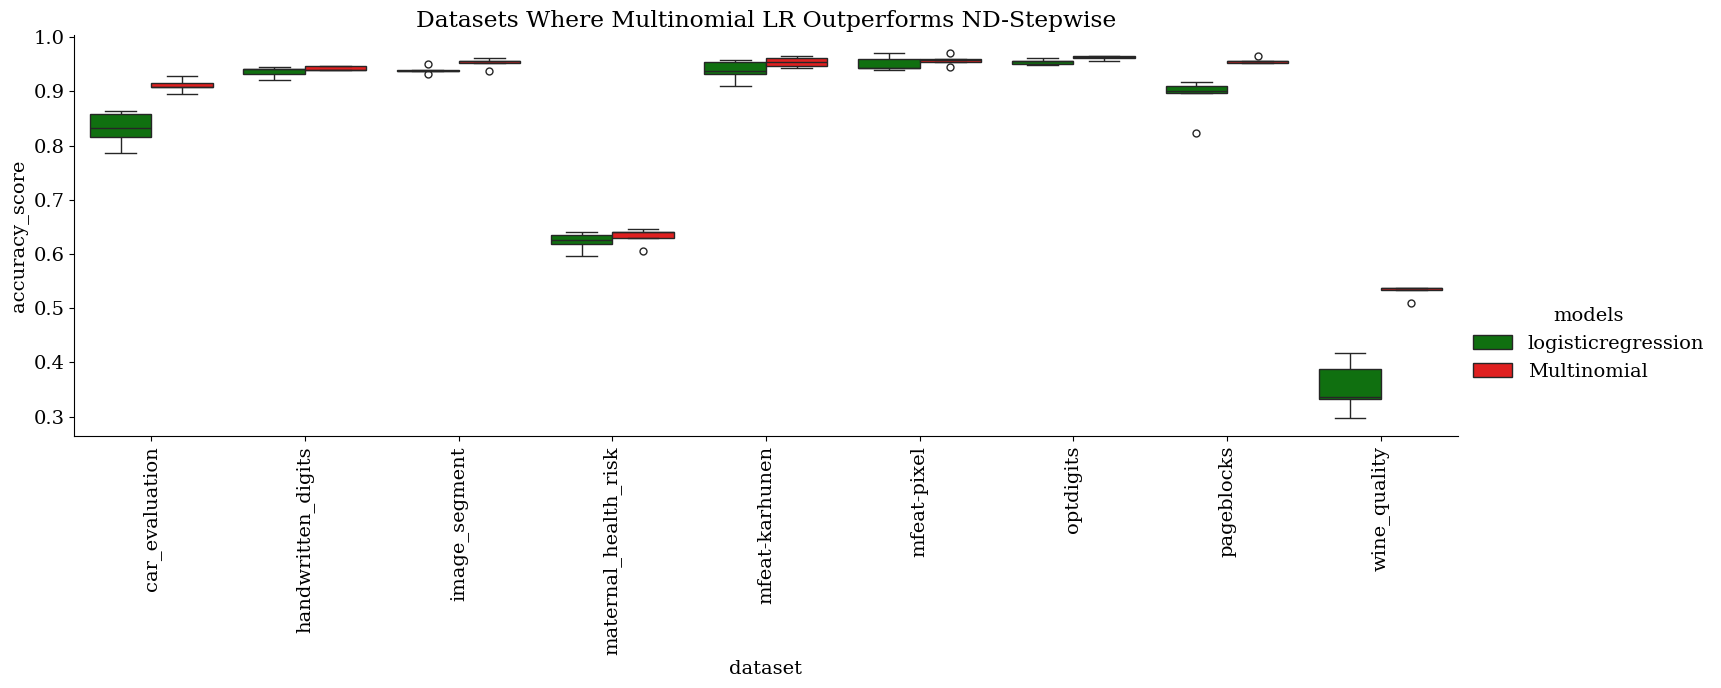

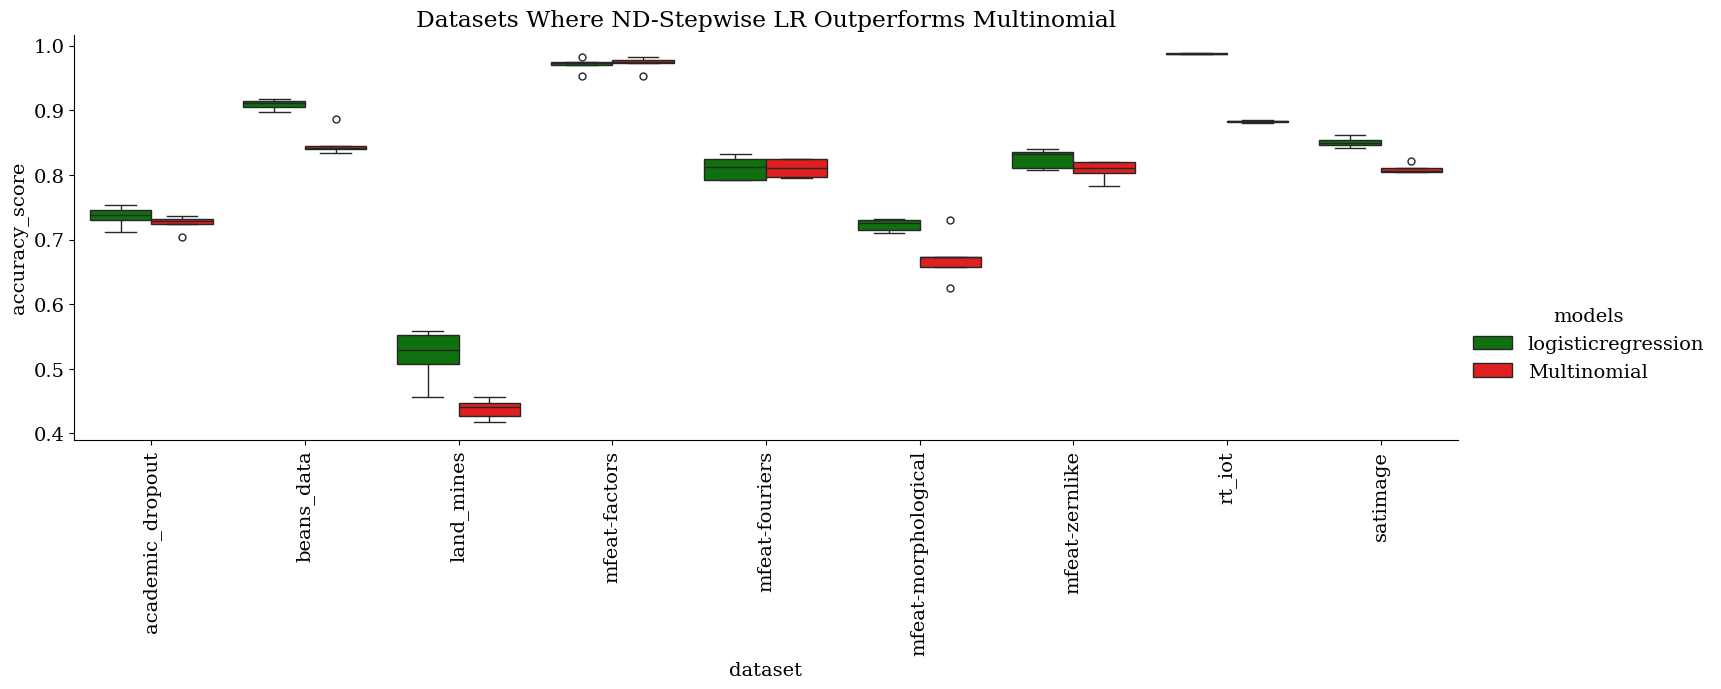

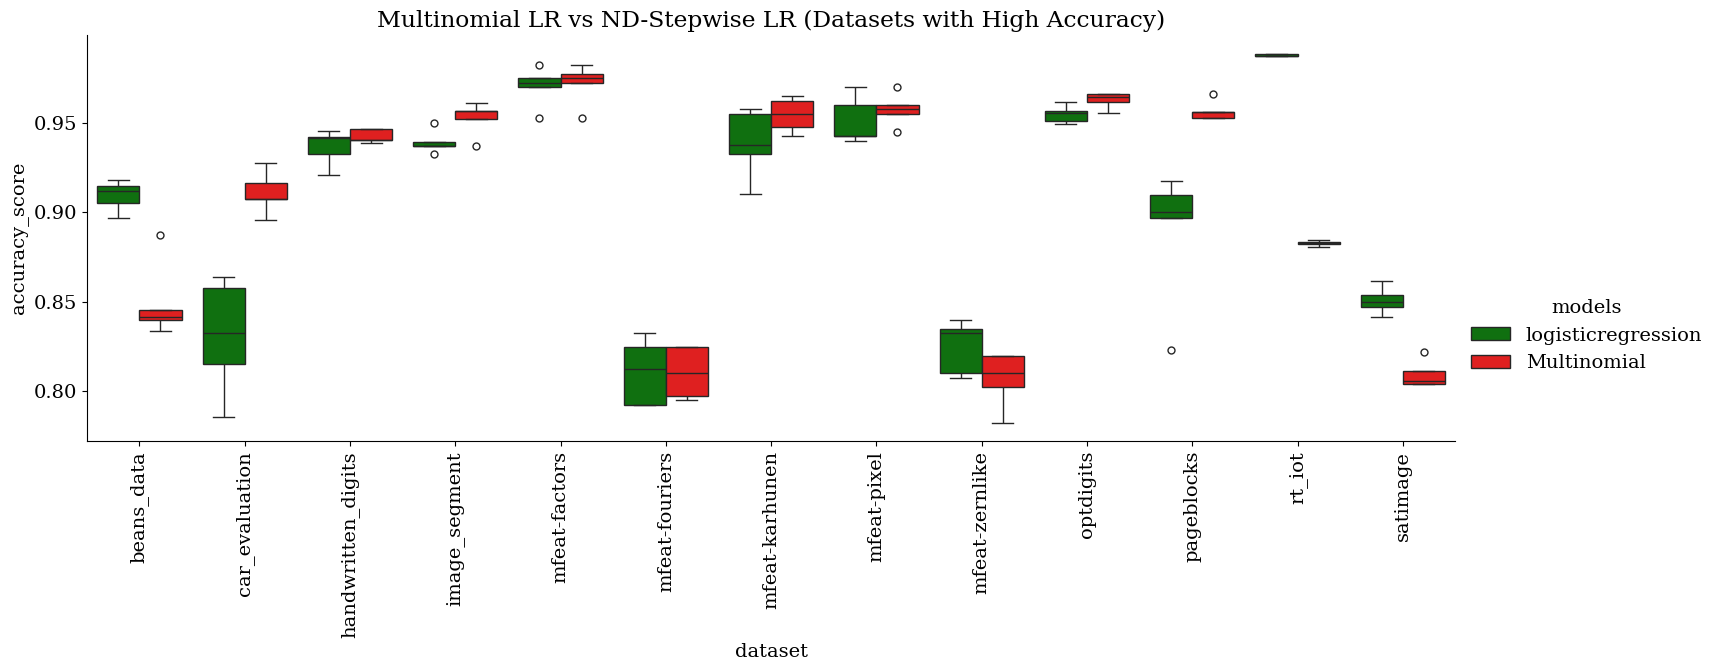

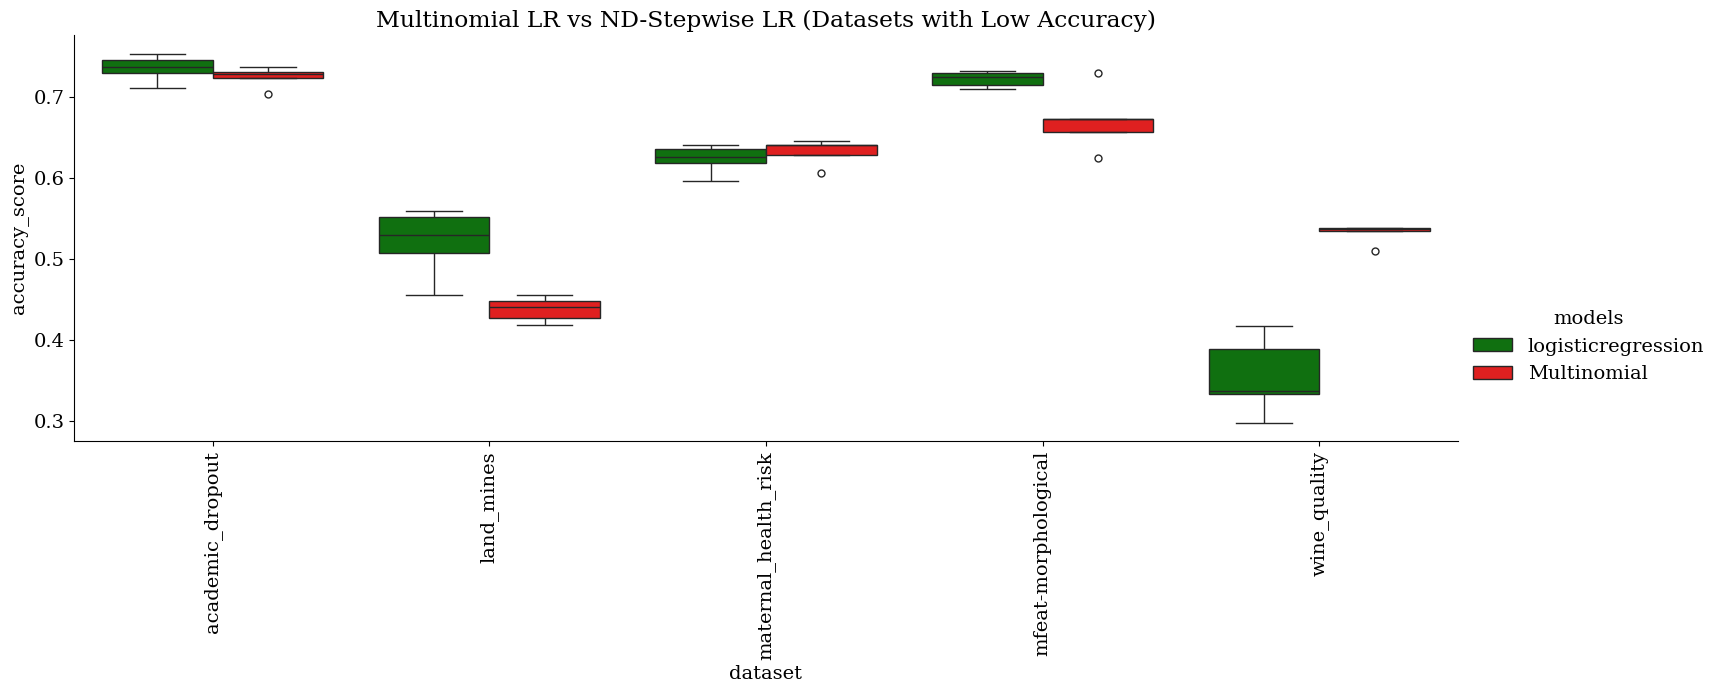

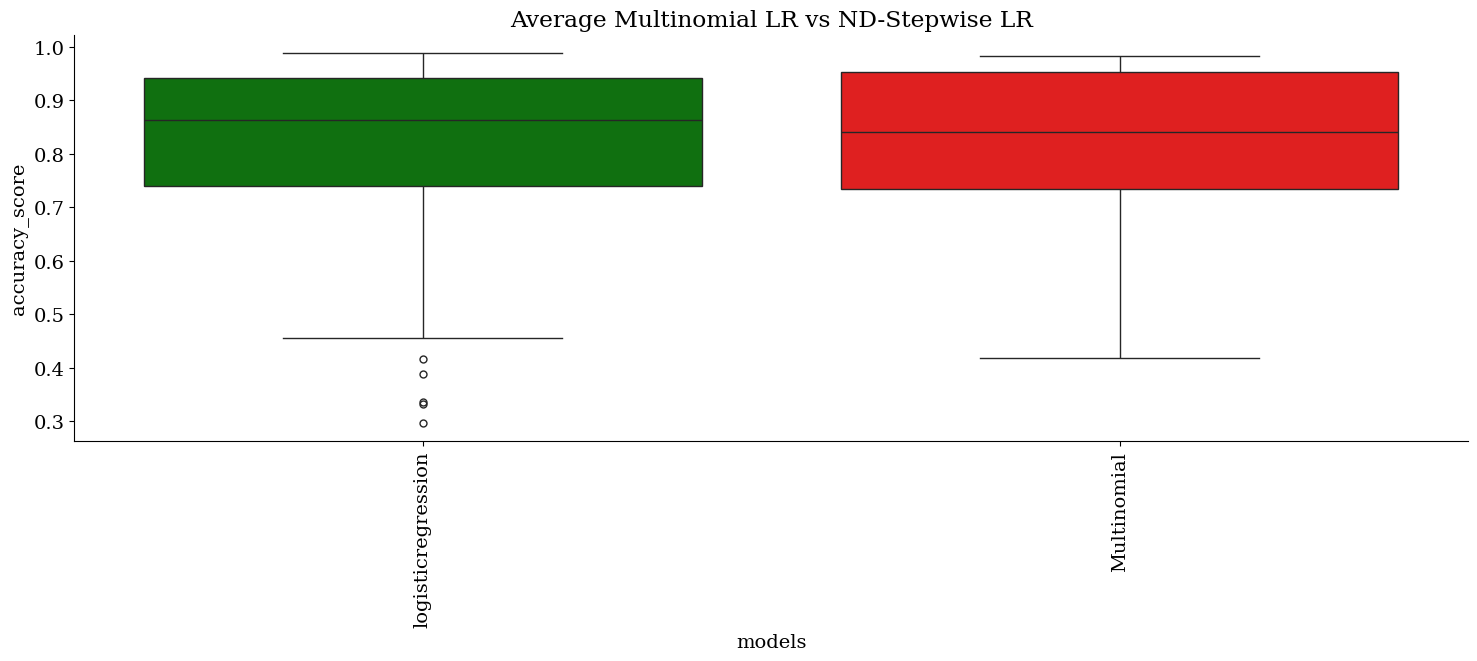

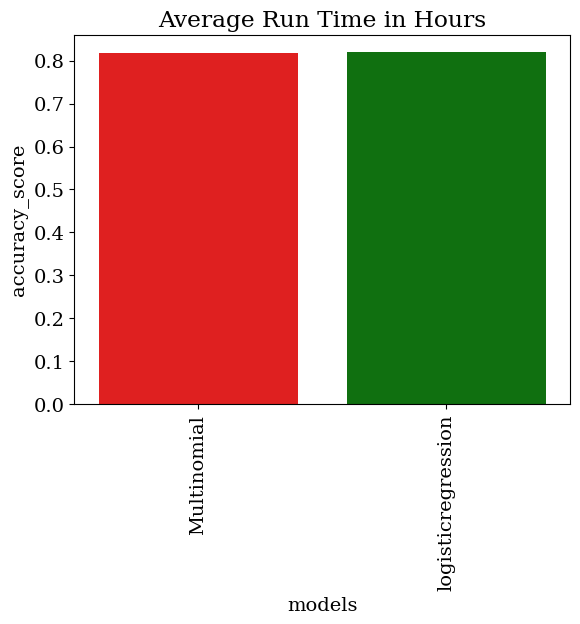

In [ ]:
# Boxplots ND-Stepwise LR vs Multinomial LR
nd_model = "logisticregression"
competitor_model = "Multinomial"
palette = {
    nd_model: 'green', 
    competitor_model: 'red'     
}
sql_query = f"""
WITH all_together as (
    SELECT MAX(run_timestamp) as run_timestamp, dataset, models, accuracy_score FROM nd_model_registry 
WHERE models = '{nd_model}' and inner_kfolds = 0 group by dataset, models, kfold
UNION all
SELECT MAX(run_timestamp), dataset, model, accuracy FROM competitor_model_registry 
WHERE model = '{competitor_model}' group by dataset, model, kfold
)
SELECT dataset, models, accuracy_score FROM all_together;
"""
df_first_read = pd.read_sql_query(sql_query, conn)
datasets_better_in_multinomial = []
datasets_better_in_nd = []

for dataset in datasets:
    df = df_first_read.loc[df_first_read['dataset'] == dataset]
    model_difference = df.loc[df['models'] == competitor_model]['accuracy_score'].mean() - df.loc[df['models'] == nd_model]['accuracy_score'].mean()
    if model_difference > 0.005:
        datasets_better_in_multinomial.append(dataset)
    else:
        datasets_better_in_nd.append(dataset)

df = df_first_read.loc[df_first_read['dataset'].isin(datasets_better_in_multinomial)]
pf.make_box_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="models", title="Datasets Where Multinomial LR Outperforms ND-Stepwise", palette=palette)

df = df_first_read.loc[df_first_read['dataset'].isin(datasets_better_in_nd)]
pf.make_box_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="models", title="Datasets Where ND-Stepwise LR Outperforms Multinomial", palette=palette)

df = df_first_read.loc[~df_first_read['dataset'].isin(["land_mines","academic_dropout","maternal_health_risk","wine_quality","mfeat-morphological","letter"])]
pf.make_box_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="models", title="Multinomial LR vs ND-Stepwise LR (Datasets with High Accuracy)", palette=palette)


df = df_first_read.loc[df_first_read['dataset'].isin(["land_mines","academic_dropout","maternal_health_risk","wine_quality","mfeat-morphological"])]
pf.make_box_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="models", title="Multinomial LR vs ND-Stepwise LR (Datasets with Low Accuracy)", palette=palette)
df = df_first_read
pf.make_box_plot(df, x_axis="models", y_axis="accuracy_score", hue="models", title="Average Multinomial LR vs ND-Stepwise LR", palette=palette)

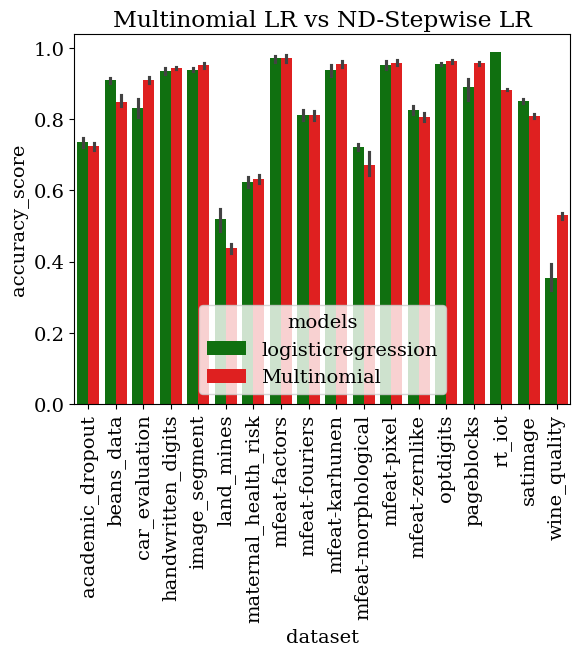

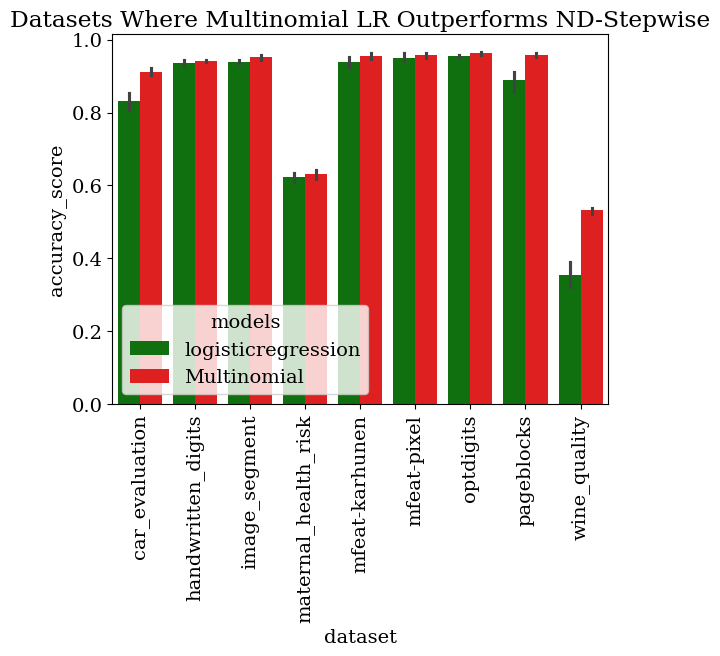

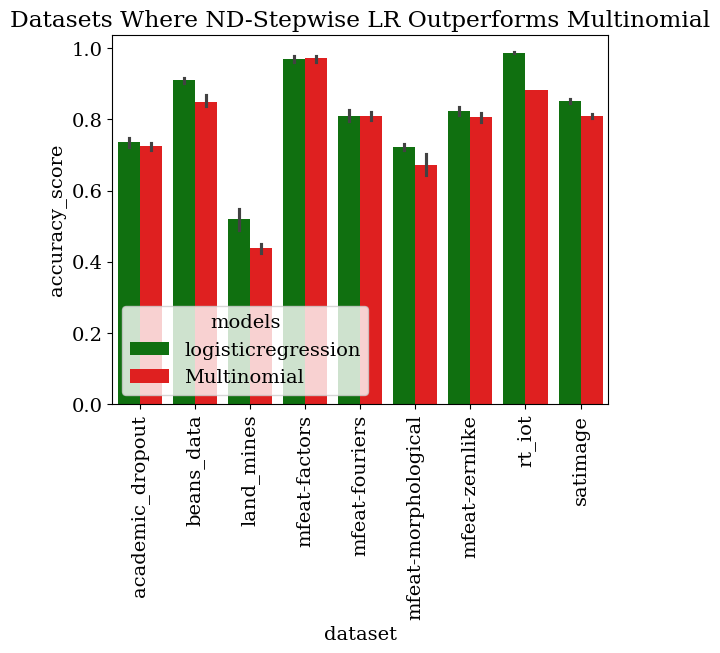

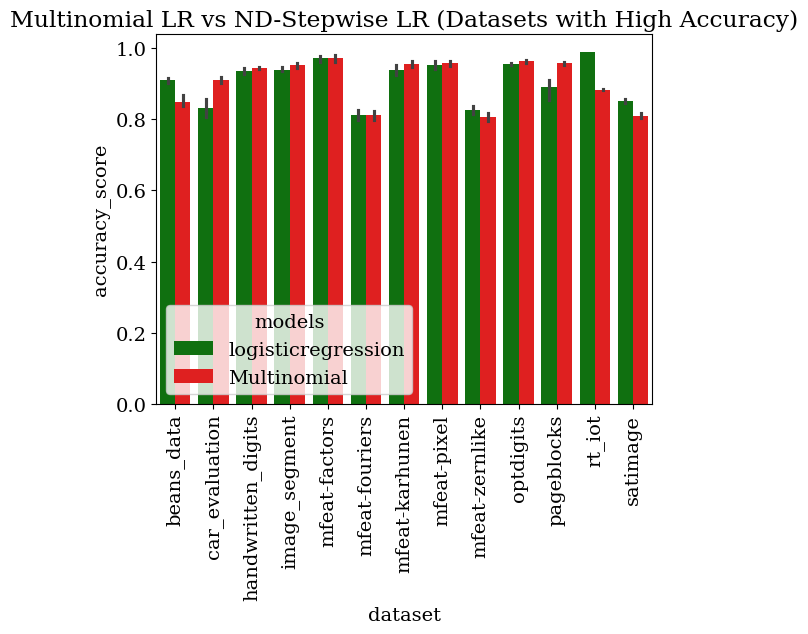

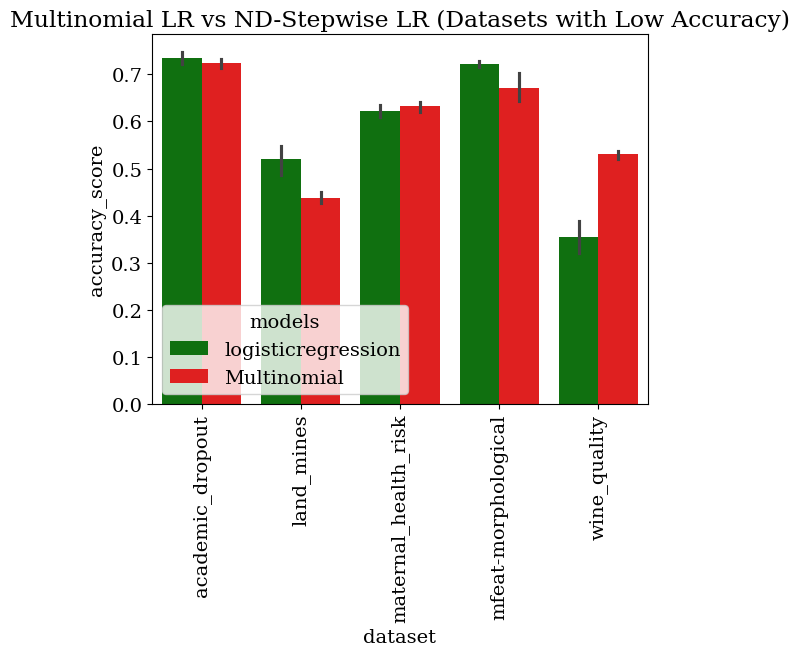

In [ ]:
# Barplots ND-Stepwise LR vs Multinomial LR

df = df_first_read.loc[df_first_read['dataset'].isin(datasets)]
pf.make_bar_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="models", title="Multinomial LR vs ND-Stepwise LR", palette=palette)

df = df_first_read.loc[df_first_read['dataset'].isin(datasets_better_in_multinomial)]
pf.make_bar_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="models", title="Datasets Where Multinomial LR Outperforms ND-Stepwise", palette=palette)


df = df_first_read.loc[df_first_read['dataset'].isin(datasets_better_in_nd)]
pf.make_bar_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="models", title="Datasets Where ND-Stepwise LR Outperforms Multinomial", palette=palette)


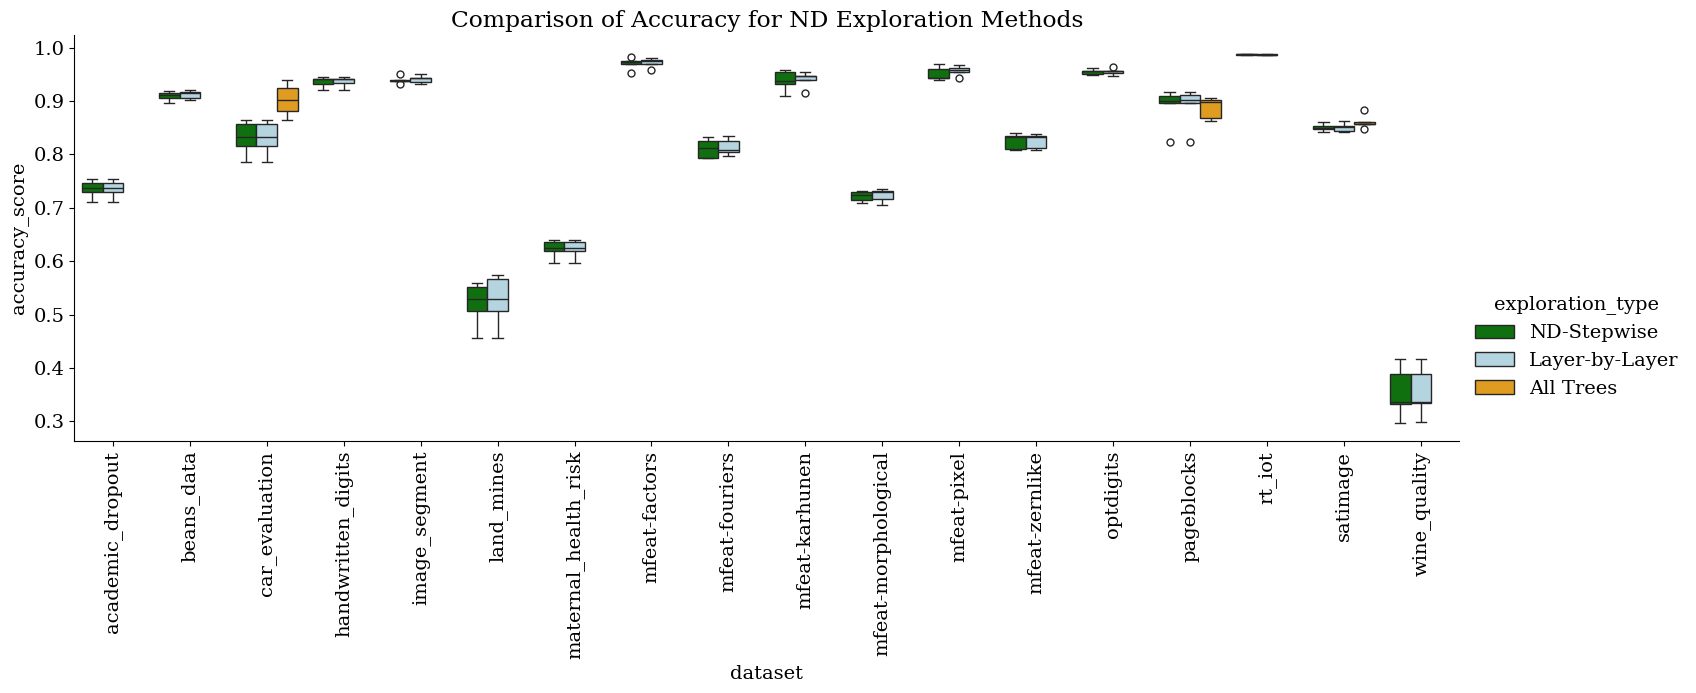

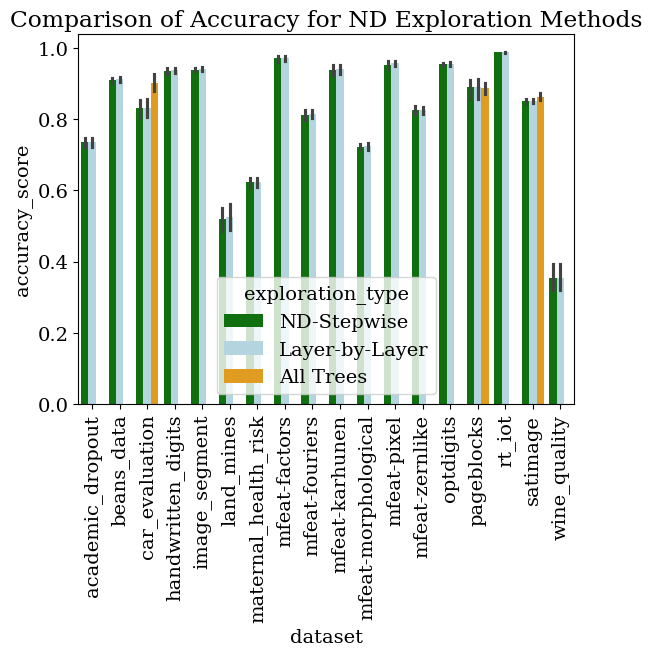

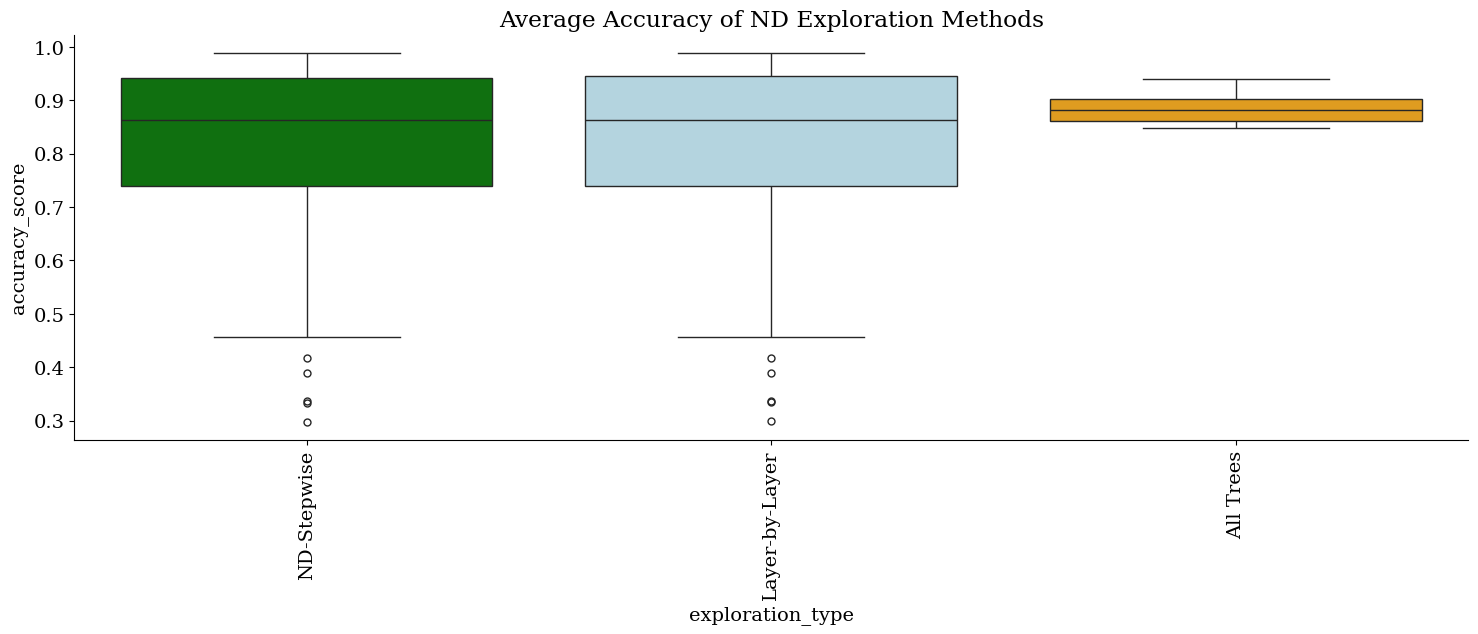

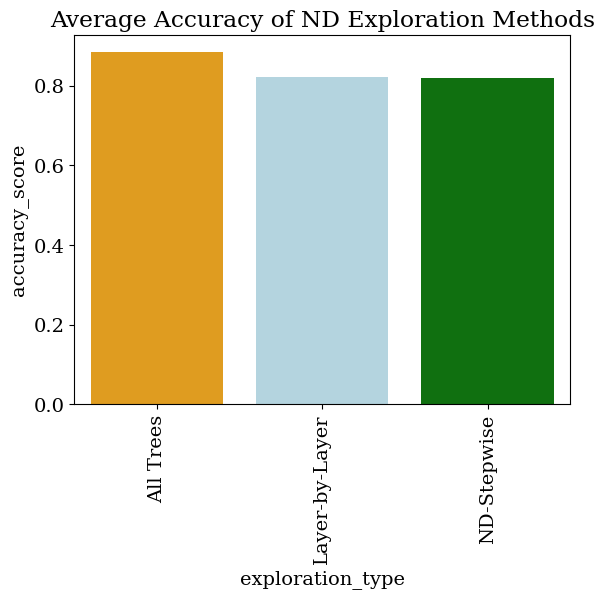

In [10]:
# Plots of accuracy for ND-All Trees, ND-All Layers, ND-Stepwise LR
nd_model = "logisticregression"
palette = {
    'ND-Stepwise': 'green', 
    'Layer-by-Layer': 'lightblue',
    'All Trees': 'orange'    
}
sql_query = f"""
WITH all_together as (
    SELECT MAX(run_timestamp) as run_timestamp, 'ND-Stepwise' as exploration_type, dataset, models, accuracy_score FROM nd_model_registry 
WHERE models = '{nd_model}' and inner_kfolds = 0 group by dataset, models, kfold
UNION all
    SELECT MAX(run_timestamp) as run_timestamp, 'Layer-by-Layer' as exploration_type, dataset, models, accuracy_score FROM layer_by_layer_model_registry 
WHERE models = '{nd_model}' group by dataset, models, kfold
UNION all
    SELECT MAX(run_timestamp) as run_timestamp, 'All Trees' as exploration_type, dataset, models, accuracy_score FROM all_trees_model_registry 
WHERE models = '{nd_model}' group by dataset, models, kfold
)
SELECT exploration_type, dataset, models, accuracy_score FROM all_together
"""
df_first_read = pd.read_sql_query(sql_query, conn)

df = df_first_read
pf.make_box_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="exploration_type", title="Comparison of Accuracy for ND Exploration Methods", palette=palette)
pf.make_bar_plot(df, x_axis="dataset", y_axis="accuracy_score", hue="exploration_type", title="Comparison of Accuracy for ND Exploration Methods", palette=palette)
pf.make_box_plot(df, x_axis='exploration_type', y_axis='accuracy_score', hue='exploration_type', title="Average Accuracy of ND Exploration Methods", palette=palette)

df = df_first_read.groupby('exploration_type', as_index=False)['accuracy_score'].mean()
pf.make_bar_plot(df, x_axis='exploration_type', y_axis='accuracy_score', hue='exploration_type', title="Average Accuracy of ND Exploration Methods", palette=palette)

Total run time for logisticregression NDs is 333.0 hrs or 14.0 days


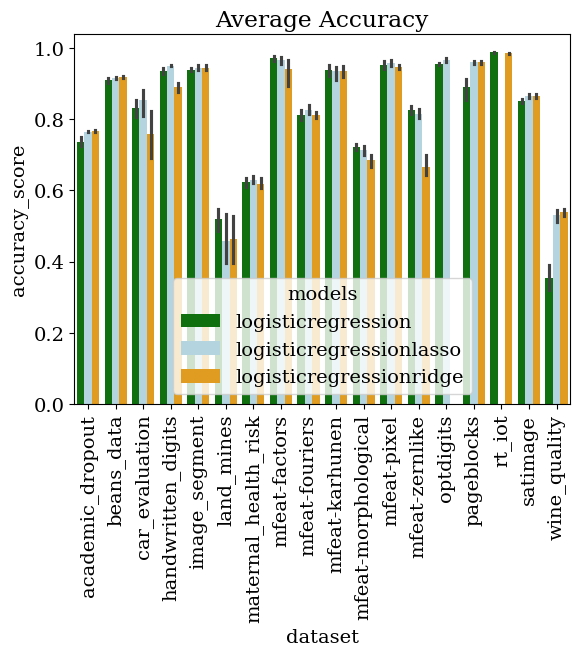

In [2]:
# Bargraph of run-time for ND-All Trees, ND-All Layers, ND-Stepwise LR
nd_model = "logisticregression"
palette = {
    'logisticregression': 'green', 
    'logisticregressionlasso': 'lightblue',
    'logisticregressionridge': 'orange'    
}
sql_query = f"""
WITH all_together as (
    SELECT MAX(run_timestamp) as run_timestamp, dataset, models, run_time_seconds, accuracy_score FROM nd_model_registry 
WHERE models = '{nd_model}' and inner_kfolds = 0 group by dataset, models, kfold
UNION all
    SELECT MAX(run_timestamp) as run_timestamp, dataset, models, run_time_seconds, accuracy_score FROM nd_model_registry 
WHERE models = '{nd_model}lasso' and inner_kfolds = 0 group by dataset, models, kfold
UNION all
    SELECT MAX(run_timestamp) as run_timestamp, dataset, models, run_time_seconds, accuracy_score FROM nd_model_registry 
WHERE models = '{nd_model}ridge' and inner_kfolds = 0 group by dataset, models, kfold
)
SELECT dataset, models, run_time_seconds/3600 as run_time_hours, accuracy_score FROM all_together
"""
df_first_read = pd.read_sql_query(sql_query, conn)

dataset_info_sql = """
SELECT name, classes, features FROM dataset_info
"""
dataset_df = pd.read_sql_query(dataset_info_sql, conn)

print(f"Total run time for {nd_model} NDs is {round(df_first_read['run_time_hours'].sum(),0)} hrs or {round(df_first_read['run_time_hours'].sum()/24,0)} days")

pf.make_bar_plot(df=df_first_read, x_axis='dataset', y_axis='accuracy_score', hue='models', title="Average Accuracy", dodge=False, palette=palette)


# df = df_first_read.groupby('exploration_type', as_index=False)['run_time_hours'].mean()
# pf.make_bar_plot(df=df, x_axis='exploration_type', y_axis='run_time_hours', hue='exploration_type', title="Average Run Time in Hours", dodge=False, palette={'ND-Stepwise': 'green', 'Layer-by-Layer': 'grey','All Trees': 'grey'}, log=True)

# df = df_first_read
# pf.make_box_plot(df=df, x_axis='exploration_type', y_axis='run_time_hours', hue='exploration_type', title="Average Run Time in Hours", dodge=False, palette={'ND-Stepwise': 'green', 'Layer-by-Layer': 'grey','All Trees': 'grey'}, log=True)



# LR w Lasso, Ridge

Total run time for logisticregression NDs is 333.0 hrs or 14.0 days


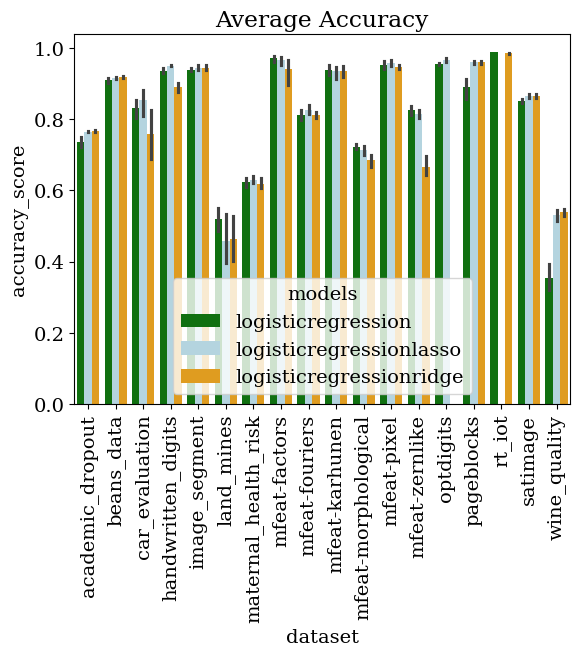

In [3]:
# Bargraph of run-time for ND-All Trees, ND-All Layers, ND-Stepwise LR
nd_model = "logisticregression"
palette = {
    'logisticregression': 'green', 
    'logisticregressionlasso': 'lightblue',
    'logisticregressionridge': 'orange'    
}
sql_query = f"""
WITH all_together as (
    SELECT MAX(run_timestamp) as run_timestamp, dataset, models, run_time_seconds, accuracy_score FROM nd_model_registry 
WHERE models = '{nd_model}' and inner_kfolds = 0 group by dataset, models, kfold
UNION all
    SELECT MAX(run_timestamp) as run_timestamp, dataset, models, run_time_seconds, accuracy_score FROM nd_model_registry 
WHERE models = '{nd_model}lasso' and inner_kfolds = 0 group by dataset, models, kfold
UNION all
    SELECT MAX(run_timestamp) as run_timestamp, dataset, models, run_time_seconds, accuracy_score FROM nd_model_registry 
WHERE models = '{nd_model}ridge' and inner_kfolds = 0 group by dataset, models, kfold
)
SELECT dataset, models, run_time_seconds/3600 as run_time_hours, accuracy_score FROM all_together
"""

print(f"Total run time for {nd_model} NDs is {round(df_first_read['run_time_hours'].sum(),0)} hrs or {round(df_first_read['run_time_hours'].sum()/24,0)} days")

pf.make_bar_plot(df=df_first_read, x_axis='dataset', y_axis='accuracy_score', hue='models', title="Average Accuracy", dodge=False, palette=palette)


In [12]:
conn.close()